In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from GP_class import GaussianProcessRegressor

In [2]:
#  read from results for X_init, [n_init, dim]; Y_sample_multi, [n_init, n_f]
noise=1e-3
n_init=178
file_name = "results_2_1.csv"
X_data = pd.read_csv(file_name, usecols=[0, 1, 2], nrows=n_init)
X_init = X_data.values
Y_data = pd.read_csv(file_name, usecols=[3, 4, 5], nrows=n_init)
Y_sample_multi = - Y_data.values
n_samples = Y_sample_multi.shape[0]
n_f = Y_sample_multi.shape[1] # number of functions
Y_sample_multi = Y_sample_multi.T.reshape(n_f, n_samples, 1) # [n_f, n_samples, 1]
gpr_list = [GaussianProcessRegressor(sigma_y=noise) for _ in range(n_f)]

# Initialize samples
X_sample = X_init
for _, (Y_sample, gpr) in enumerate(zip(Y_sample_multi, gpr_list)):
    gpr.fit(X_sample, Y_sample)
    gpr.optim_np()

fixed_value = 0.8 # eta_eno=0.8

# Create meshes for 2D slicing
y = np.linspace(X_init[:, 1].min(), X_init[:, 1].max(), 100) # eta_v
z = np.linspace(X_init[:, 2].min(), X_init[:, 2].max(), 100) # ducros_cutoff
Y, Z = np.meshgrid(y, z)
X= np.hstack((np.full(y.reshape(-1, 1).shape, fixed_value), y.reshape(-1, 1), z.reshape(-1, 1)))
X_grid= np.hstack((np.full(Y.reshape(-1, 1).shape, fixed_value), Y.reshape(-1, 1), Z.reshape(-1, 1)))


In [3]:

def plot_gp_3D(mu, cov, X, X_train=None, Y_train=None, fixed_inputs=[], samples=[], save_path=None):
    """
    Plots the results of a Gaussian Process regression for three inputs, focusing on a 2D slice of the input space.

    Args:
        mu: Array representing the mean values of the Gaussian Process predictions across the 2D slice.
        cov: Covariance matrix of the Gaussian Process predictions across the 2D slice.
        X: Grid locations for plotting in the 2D slice, shaped (n_points, 2).
        X_train: Training input locations in the full 3D space (if available), shaped (n_samples, 3).
        Y_train: Training target values (if available).
        fixed_inputs: List of tuples representing the inputs that are held fixed. Each tuple contains the index
            of the fixed input and its value, e.g., [(2, 0.5)] for fixing the third input at 0.5.
        samples: List of sample predictions to be plotted across the 2D slice.
        save_path: Path to save the plot as an image file (e.g., 'plot.png').

    Returns:
        None
    """
    # Ensure inputs are in the correct shape
    mu = mu.ravel()
    X1, X2 = np.meshgrid(X[:,0], X[:,1])
    uncertainty = 1.96 * np.sqrt(np.diag(cov)).reshape(X1.shape)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface for mean predictions
    ax.plot_surface(X1, X2, mu.reshape(X1.shape), cmap='viridis', alpha=0.7)
    ax.contourf(X1, X2, mu.reshape(X1.shape) + uncertainty, zdir='z', offset=mu.min(), cmap='viridis', alpha=0.3)
    ax.contourf(X1, X2, mu.reshape(X1.shape) - uncertainty, zdir='z', offset=mu.min(), cmap='viridis', alpha=0.3)

    # Plot samples if available
    for sample in samples:
        ax.plot_surface(X1, X2, sample.reshape(X1.shape), cmap='coolwarm', alpha=0.3, linewidth=0)

    # Plot training data if available
    if X_train is not None and Y_train is not None:
        # Filter training points that match the fixed inputs
        match_fixed_input = np.all([X_train[:, idx] == value for idx, value in fixed_inputs], axis=0)
        ax.scatter(X_train[match_fixed_input, 0], X_train[match_fixed_input, 1], Y_train[match_fixed_input], color='r')

    # Adding title and labels
    ax.set_title("Gaussian Process for disper model")
    ax.set_xlabel("eta_v")
    ax.set_ylabel("ducros_cutoff")
    ax.set_zlabel("- f_disper")
    
    # plt.show()

    if save_path:
        plt.savefig(save_path)


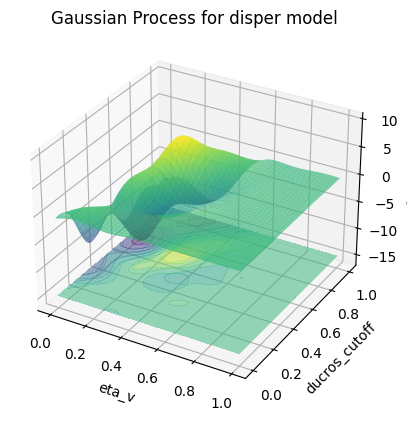

In [4]:
# the first model: f_disper
mu, cov = gpr_list[0].predict(X_grid, return_cov=True) 
plot_gp_3D(mu, cov, X[:, 1:], X_train=X_init, Y_train=Y_sample_multi[0, :], fixed_inputs=[(0, fixed_value)], save_path='gp_fdisper_fixed_x1.png')

In [5]:

def plot_gp_3D(mu, cov, X, X_train=None, Y_train=None, fixed_inputs=[], samples=[], save_path=None):
    """
    Plots the results of a Gaussian Process regression for three inputs, focusing on a 2D slice of the input space.

    Args:
        mu: Array representing the mean values of the Gaussian Process predictions across the 2D slice.
        cov: Covariance matrix of the Gaussian Process predictions across the 2D slice.
        X: Grid locations for plotting in the 2D slice, shaped (n_points, 2).
        X_train: Training input locations in the full 3D space (if available), shaped (n_samples, 3).
        Y_train: Training target values (if available).
        fixed_inputs: List of tuples representing the inputs that are held fixed. Each tuple contains the index
            of the fixed input and its value, e.g., [(2, 0.5)] for fixing the third input at 0.5.
        samples: List of sample predictions to be plotted across the 2D slice.
        save_path: Path to save the plot as an image file (e.g., 'plot.png').

    Returns:
        None
    """
    # Ensure inputs are in the correct shape
    mu = mu.ravel()
    X1, X2 = np.meshgrid(X[:,0], X[:,1])
    uncertainty = 1.96 * np.sqrt(np.diag(cov)).reshape(X1.shape)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface for mean predictions
    ax.plot_surface(X1, X2, mu.reshape(X1.shape), cmap='viridis', alpha=0.7)
    ax.contourf(X1, X2, mu.reshape(X1.shape) + uncertainty, zdir='z', offset=mu.min(), cmap='viridis', alpha=0.3)
    ax.contourf(X1, X2, mu.reshape(X1.shape) - uncertainty, zdir='z', offset=mu.min(), cmap='viridis', alpha=0.3)

    # Plot samples if available
    for sample in samples:
        ax.plot_surface(X1, X2, sample.reshape(X1.shape), cmap='coolwarm', alpha=0.3, linewidth=0)

    # Plot training data if available
    if X_train is not None and Y_train is not None:
        # Filter training points that match the fixed inputs
        match_fixed_input = np.all([X_train[:, idx] == value for idx, value in fixed_inputs], axis=0)
        ax.scatter(X_train[match_fixed_input, 0], X_train[match_fixed_input, 1], Y_train[match_fixed_input], color='r')

    # Adding title and labels
    ax.set_title("Gaussian Process for tke model")
    ax.set_xlabel("eta_v")
    ax.set_ylabel("ducros_cutoff")
    ax.set_zlabel("- f_tke")
    
    # plt.show()

    if save_path:
        plt.savefig(save_path)


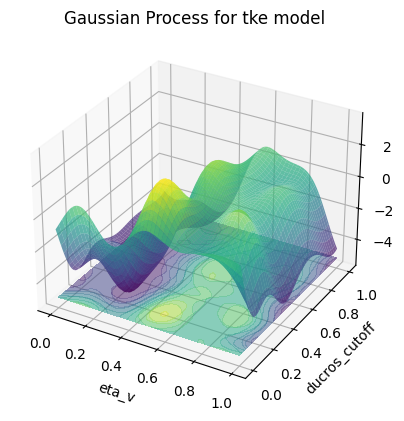

In [6]:
# the 2nd model: f_tke
mu, cov = gpr_list[1].predict(X_grid, return_cov=True) 
plot_gp_3D(mu, cov, X[:, 1:], X_train=X_init, Y_train=Y_sample_multi[0, :], fixed_inputs=[(0, fixed_value)], save_path='gp_ftke_fixed_x1.png')

In [7]:

def plot_gp_3D(mu, cov, X, X_train=None, Y_train=None, fixed_inputs=[], samples=[], save_path=None):
    """
    Plots the results of a Gaussian Process regression for three inputs, focusing on a 2D slice of the input space.

    Args:
        mu: Array representing the mean values of the Gaussian Process predictions across the 2D slice.
        cov: Covariance matrix of the Gaussian Process predictions across the 2D slice.
        X: Grid locations for plotting in the 2D slice, shaped (n_points, 2).
        X_train: Training input locations in the full 3D space (if available), shaped (n_samples, 3).
        Y_train: Training target values (if available).
        fixed_inputs: List of tuples representing the inputs that are held fixed. Each tuple contains the index
            of the fixed input and its value, e.g., [(2, 0.5)] for fixing the third input at 0.5.
        samples: List of sample predictions to be plotted across the 2D slice.
        save_path: Path to save the plot as an image file (e.g., 'plot.png').

    Returns:
        None
    """
    # Ensure inputs are in the correct shape
    mu = mu.ravel()
    X1, X2 = np.meshgrid(X[:,0], X[:,1])
    uncertainty = 1.96 * np.sqrt(np.diag(cov)).reshape(X1.shape)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface for mean predictions
    ax.plot_surface(X1, X2, mu.reshape(X1.shape), cmap='viridis', alpha=0.7)
    ax.contourf(X1, X2, mu.reshape(X1.shape) + uncertainty, zdir='z', offset=mu.min(), cmap='viridis', alpha=0.3)
    ax.contourf(X1, X2, mu.reshape(X1.shape) - uncertainty, zdir='z', offset=mu.min(), cmap='viridis', alpha=0.3)

    # Plot samples if available
    for sample in samples:
        ax.plot_surface(X1, X2, sample.reshape(X1.shape), cmap='coolwarm', alpha=0.3, linewidth=0)

    # Plot training data if available
    if X_train is not None and Y_train is not None:
        # Filter training points that match the fixed inputs
        match_fixed_input = np.all([X_train[:, idx] == value for idx, value in fixed_inputs], axis=0)
        ax.scatter(X_train[match_fixed_input, 0], X_train[match_fixed_input, 1], Y_train[match_fixed_input], color='r')

    # Adding title and labels
    ax.set_title("Gaussian Process for cons model")
    ax.set_xlabel("eta_v")
    ax.set_ylabel("ducros_cutoff")
    ax.set_zlabel("- f_cons")
    
    # plt.show()

    if save_path:
        plt.savefig(save_path)


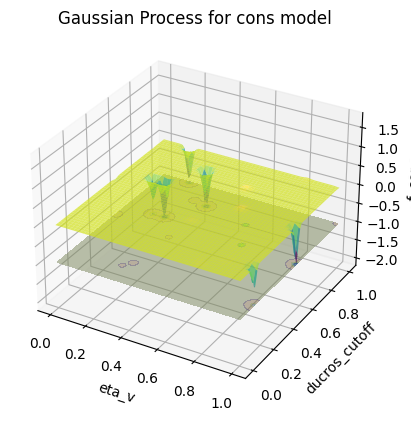

In [8]:
# the 3rd model: f_cons
mu, cov = gpr_list[2].predict(X_grid, return_cov=True) 
plot_gp_3D(mu, cov, X[:, 1:], X_train=X_init, Y_train=Y_sample_multi[0, :], fixed_inputs=[(0, fixed_value)], save_path='gp_fcons_fixed_x1.png')